In [2]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## Image Preprocessing
---

In [14]:
preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# origial = cv2.imread("components/image_preprocessing/elefant.jpeg")
_, origial_encoded = cv2.imencode('.png', origial)
original_base64 = base64.b64encode(origial_encoded).decode('utf-8')


# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)
_, gray_encoded = cv2.imencode('.png', gray)
gray_base64 = base64.b64encode(gray_encoded).decode('utf-8')

# Rauschen eliminieren
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, blurred_encoded = cv2.imencode('.png', blurred)
blurred_base64 = base64.b64encode(blurred_encoded).decode('utf-8')

# Canny-Kanten-Detektor
edges = cv2.Canny(blurred, 100, 200)
_, edges_encoded = cv2.imencode('.png', edges)

# Kantenbreite (4 Pixel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated = cv2.dilate(edges, kernel)
_, dilated_encoded = cv2.imencode('.png', dilated)

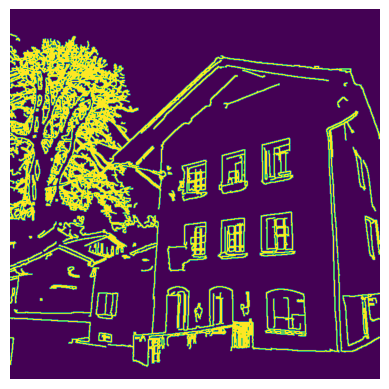

In [15]:
plt.imshow(dilated)
plt.axis('off')  # Remove the axis labels
plt.show()

In [16]:
path = "gcode.tap"


z_safe_hight = 10.0
z_working_hight = 0.5
z_depth = 3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000
def generate_gcode(contours):
    gcode_data = []

    # set contour to (0|0)
    minX = 1000
    maxX = 0
    minY = 1000
    maxY = 0

    for count, c in enumerate(contours):
        tmp_minX = np.min(c[:, :, 0])
        tmp_minY = np.min(c[:, :, 1])
        tmp_maxX = np.max(c[:, :, 0])
        tmp_maxY = np.max(c[:, :, 1])
        if tmp_minX < minX:
            minX = tmp_minX
        if tmp_minY < minY:
            minY = tmp_minY
        if tmp_maxX > maxX:
            maxX = tmp_maxX
        if tmp_maxY > maxY:
            maxY = tmp_maxY

    contours_lists = []
    for contour in contours:
        contour_list = []
        for points in contour:
            contour_list.append([points[0][0] - minX, points[0][1] - minY])

        # TODO Drop duplicates
        contours_lists.append(contour_list)

    # write g-code
    gcode_start = [f"M03 S{spindle_speed}",
                   f"G00 Z{z_safe_hight}"]
    gcode_end = [f"G00 Z{z_safe_hight}", "G00 X0 Y0", "M05", "M30"]

    gcode_data = []

    for elem in gcode_start:
        gcode_data.append(f"{elem}\n")

    for contour in contours_lists:

        tmp_contour_len = len(contour)
        gcode_data.append(
            f"{tmp_contour_len}#####################################\n")

        gcode_data.append(f"G00 X{contour[0][0]} Y{contour[0][1]}\n")
        gcode_data.append(f"G00 Z0\n")
        gcode_data.append(f"G01 Z-{z_depth} F{z_feed}\n")

        if tmp_contour_len == 2:
            gcode_data.append(
                f"G01 X{contour[1][0]} Y{contour[1][1]} F{xy_feed}\n")

        gcode_data.append(f"G00 Z{z_working_hight}\n")

        if tmp_contour_len > 2:
            for i in range(tmp_contour_len-1):
                if i == 0:
                    gcode_data.append(
                        f"G01 X{contour[i+1][0]} Y{contour[i+1][1]} F{xy_feed}\n")
                else:
                    gcode_data.append(
                        f"G01 X{contour[i+1][0]} Y{contour[i+1][1]}\n")
            gcode_data.append(f"G00 Z{z_working_hight}\n")

    for elem in gcode_end:
        gcode_data.append(f"{elem}\n")

    # return gcode_data
    # Save the G-code to a file
    with open(path, "w") as f:
        f.writelines(gcode_data)

def get_contours(dilated, contour_minArcLength=0):
    contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    for c in contours:
        areaContour = cv2.arcLength(c, True)
        area_min = contour_minArcLength
        area_max = 1000000000
        if areaContour < area_min or area_max < areaContour:
            continue
        else:
            final_contours.append(c)
    return final_contours

def image_to_gcode(dilated):
    resized_image = cv2.resize(dilated, (dilated.shape[1] // 2, dilated.shape[0] // 2))
    return generate_gcode(get_contours(resized_image))

In [17]:
image_to_gcode(dilated)